Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0253
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.0024
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0016
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0019
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0012
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0012
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0010
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0013
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0011
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 9.5408e-04
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 7.8793e-04
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 7.3167e-04
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 7.8663e-04
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 7.3879e-04
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step

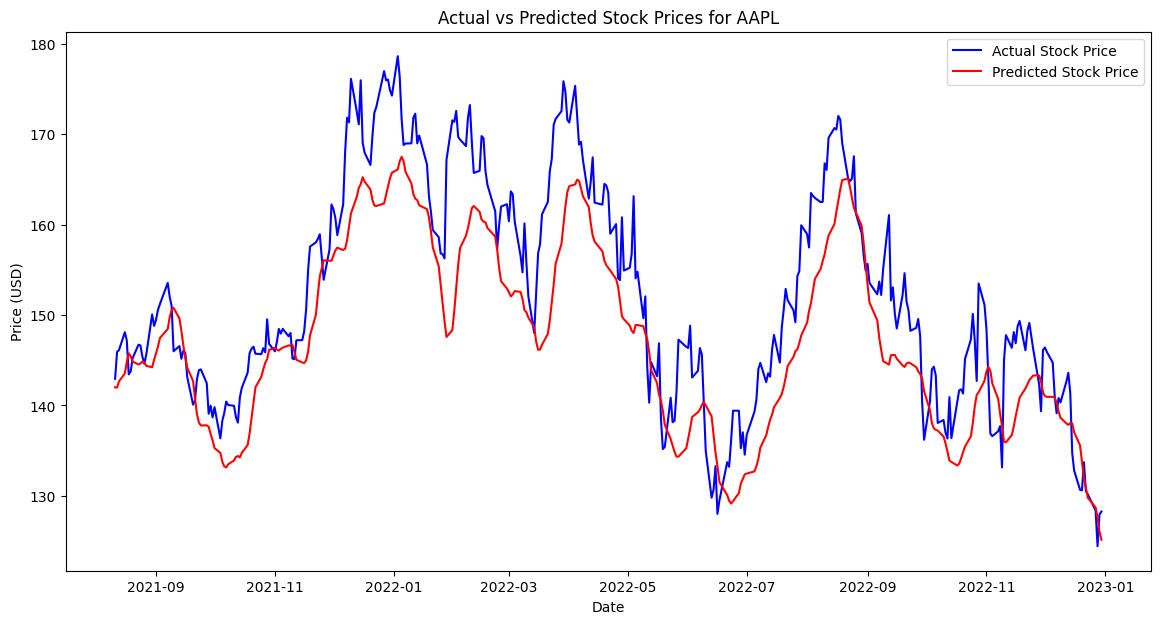

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


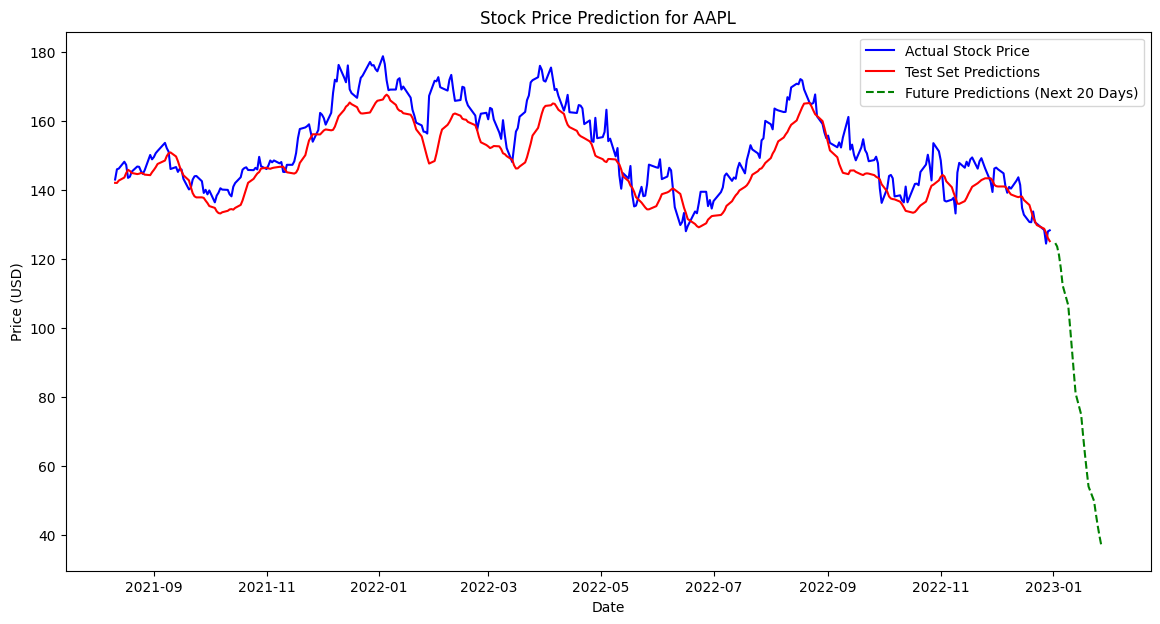

In [5]:
!pip install ta --quiet
# If running in notebook/Colab, uncomment the following line to install 'ta':
# !pip install ta --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

import ta  # Technical Analysis library

# --- 1. Download Stock Data with adjusted prices ---
stock_ticker = 'AAPL'
stock_data = yf.download(stock_ticker, start='2015-01-01', end='2023-01-01', progress=False, auto_adjust=True)

# --- 2. Add Technical Indicators ---
# Use 1D Series (squeeze) to avoid shape issues
stock_data['RSI'] = ta.momentum.RSIIndicator(stock_data['Close'].squeeze(), window=14).rsi()
stock_data['MA50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['MA200'] = stock_data['Close'].rolling(window=200).mean()

bb = ta.volatility.BollingerBands(stock_data['Close'].squeeze(), window=20)
stock_data['BB_High'] = bb.bollinger_hband()
stock_data['BB_Low'] = bb.bollinger_lband()

# Drop rows with NaN values from rolling/window calculations
stock_data.dropna(inplace=True)

# --- 3. Prepare Data for LSTM ---

features = ['Close', 'RSI', 'MA50', 'MA200', 'BB_High', 'BB_Low']
data = stock_data[features]

# Scale features to range [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

lookback_period = 60  # Number of days to look back

X = []
y = []

for i in range(lookback_period, len(scaled_data)):
    X.append(scaled_data[i - lookback_period:i])
    y.append(scaled_data[i, 0])  # Predict 'Close' price only

X, y = np.array(X), np.array(y)

# Split data into 80% training and 20% testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# --- 4. Build and Train the LSTM Model ---

model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(lookback_period, X.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)  # Predict 1 value: Close price
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to avoid overfitting
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1, callbacks=[early_stop])

# --- 5. Predict on Test Set ---

predicted_scaled = model.predict(X_test)

# To inverse scale, reconstruct full feature set with predicted Close and zeros for others
zeros = np.zeros((predicted_scaled.shape[0], scaled_data.shape[1] - 1))
predicted_full = np.concatenate((predicted_scaled, zeros), axis=1)
predicted_price = scaler.inverse_transform(predicted_full)[:, 0]

# Inverse scale actual y_test similarly
y_test_full = np.concatenate((y_test.reshape(-1, 1), zeros), axis=1)
actual_price = scaler.inverse_transform(y_test_full)[:, 0]

# --- 6. Plot Actual vs Predicted Stock Prices ---

plt.figure(figsize=(14, 7))
plt.plot(stock_data.index[-len(actual_price):], actual_price, color='blue', label='Actual Stock Price')
plt.plot(stock_data.index[-len(predicted_price):], predicted_price, color='red', label='Predicted Stock Price')
plt.title(f'Actual vs Predicted Stock Prices for {stock_ticker}')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# --- 7. Predict Future Stock Prices (Next 20 Trading Days) ---

# Start with last lookback window from scaled_data
last_window = scaled_data[-lookback_period:]

future_predictions_scaled = []

for _ in range(20):
    input_window = last_window.reshape(1, lookback_period, scaled_data.shape[1])
    pred = model.predict(input_window)[0, 0]
    future_predictions_scaled.append(pred)

    # Shift window: remove first day, append predicted Close + zeros for other features
    new_row = np.zeros(scaled_data.shape[1])
    new_row[0] = pred  # Only Close price predicted
    last_window = np.vstack([last_window[1:], new_row])

# Inverse scale future predictions
future_pred_full = np.zeros((20, scaled_data.shape[1]))
future_pred_full[:, 0] = future_predictions_scaled
future_pred_price = scaler.inverse_transform(future_pred_full)[:, 0]

# Create future dates (business days)
last_date = stock_data.index[-1]
future_dates = pd.bdate_range(last_date, periods=21)[1:]  # Skip last_date itself

# --- 8. Plot Actual, Test Predictions and Future Predictions ---

plt.figure(figsize=(14, 7))
plt.plot(stock_data.index[-len(actual_price):], actual_price, label='Actual Stock Price', color='blue')
plt.plot(stock_data.index[-len(predicted_price):], predicted_price, label='Test Set Predictions', color='red')
plt.plot(future_dates, future_pred_price, label='Future Predictions (Next 20 Days)', color='green', linestyle='--')
plt.title(f'Stock Price Prediction for {stock_ticker}')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()
